In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

In [2]:
dataset = np.load('data/database_1_fft.npz')
X_mag_fft = dataset['fourier']
y = dataset['label']

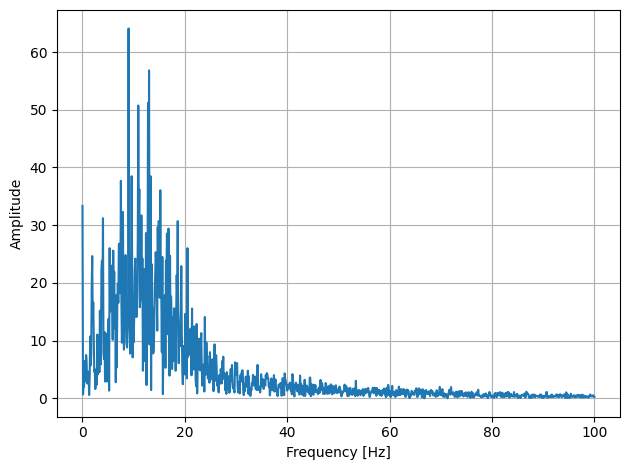

In [3]:
signal = X_mag_fft[0]
N = len(signal)
fs = 500

freqs = np.fft.fftfreq(N, 1 / fs)
positive_freqs = freqs[: N // 2]
mag_values = signal[: N // 2]

mask_100hz = positive_freqs <= 100
filtered_freqs = positive_freqs[mask_100hz]
filtered_mag_values = mag_values[mask_100hz]

plt.plot(filtered_freqs, filtered_mag_values, label='Magnitude')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.grid()
plt.tight_layout()

In [4]:
from sklearn.model_selection import train_test_split

X = X_mag_fft[:, : N // 2]
X = X[:, mask_100hz]

random_state = 420

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=420)

### BalancedRandomForest

In [6]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pca = PCA(n_components=50, random_state=random_state)
clf = BalancedRandomForestClassifier(n_estimators=100, random_state=random_state, n_jobs=os.cpu_count() - 2, verbose=2)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('pca', pca),
    ('classifier', clf)
])

param_grid = {
    'pca__n_components': [60, 80, 100, 120, 140],
    'classifier__n_estimators': [60, 80, 100, 120, 140, 160, 180, 200]
}

In [7]:
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=skf, scoring='balanced_accuracy', n_jobs=os.cpu_count() - 2, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


building tree 7 of 180building tree 6 of 180

building tree 2 of 180
building tree 1 of 180
building tree 4 of 180
building tree 5 of 180
building tree 3 of 180
building tree 8 of 180
building tree 9 of 180
building tree 10 of 180
building tree 11 of 180
building tree 12 of 180
building tree 13 of 180
building tree 16 of 180
building tree 15 of 180
building tree 14 of 180
building tree 17 of 180
building tree 18 of 180
building tree 19 of 180
building tree 20 of 180
building tree 21 of 180
building tree 22 of 180
building tree 23 of 180
building tree 24 of 180
building tree 25 of 180
building tree 26 of 180
building tree 27 of 180
building tree 28 of 180
building tree 29 of 180
building tree 30 of 180
building tree 31 of 180
building tree 32 of 180
building tree 33 of 180
building tree 34 of 180
building tree 35 of 180
building tree 36 of 180


[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.4s


building tree 38 of 180
building tree 37 of 180
building tree 39 of 180
building tree 40 of 180
building tree 41 of 180
building tree 42 of 180
building tree 43 of 180
building tree 44 of 180
building tree 45 of 180
building tree 46 of 180
building tree 47 of 180
building tree 48 of 180
building tree 49 of 180
building tree 50 of 180
building tree 51 of 180
building tree 52 of 180
building tree 53 of 180
building tree 54 of 180
building tree 55 of 180
building tree 56 of 180
building tree 57 of 180
building tree 58 of 180
building tree 59 of 180
building tree 60 of 180
building tree 62 of 180
building tree 61 of 180
building tree 63 of 180
building tree 64 of 180
building tree 65 of 180
building tree 66 of 180
building tree 67 of 180
building tree 68 of 180
building tree 69 of 180
building tree 70 of 180
building tree 71 of 180
building tree 72 of 180
building tree 73 of 180
building tree 74 of 180
building tree 75 of 180
building tree 76 of 180
building tree 77 of 180
building tree 78

[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:    2.0s


building tree 156 of 180building tree 157 of 180

building tree 158 of 180
building tree 159 of 180
building tree 160 of 180
building tree 161 of 180
building tree 162 of 180
building tree 163 of 180
building tree 164 of 180
building tree 165 of 180
building tree 166 of 180
building tree 167 of 180
building tree 168 of 180
building tree 169 of 180
building tree 170 of 180
building tree 171 of 180
building tree 172 of 180
building tree 173 of 180
building tree 174 of 180
building tree 175 of 180
building tree 176 of 180
building tree 177 of 180
building tree 178 of 180
building tree 179 of 180
building tree 180 of 180


[Parallel(n_jobs=10)]: Done 180 out of 180 | elapsed:    2.5s finished


FileNotFoundError: [Errno 2] No such file or directory: 'model/BRFC_PCA.pkl'

In [8]:
import joblib

joblib.dump(grid_search.best_estimator_, 'models/BRFC_PCA.pkl')

['models/BRFC_PCA.pkl']

In [10]:
print(f'Best parameters: {grid_search.best_params_}')

Best parameters: {'classifier__n_estimators': 180, 'pca__n_components': 60}


In [11]:
best_model = grid_search.best_estimator_
cv_score = cross_val_score(best_model, X_train, y_train, cv=skf, scoring='balanced_accuracy', n_jobs=os.cpu_count() - 2, verbose=2)
y_pred = best_model.predict(X_test)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:   16.8s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 out of 180 | elapsed:    0.0s finished


In [17]:
print(f'Test score: {cv_score.mean() : .2f} ({cv_score.std() : .2f})')
print(classification_report(y_test, y_pred))

Test score:  0.87 ( 0.00)
              precision    recall  f1-score   support

           0       0.59      0.84      0.69      1182
           1       0.97      0.91      0.94      7849

    accuracy                           0.90      9031
   macro avg       0.78      0.88      0.82      9031
weighted avg       0.92      0.90      0.91      9031



---

### BalancedBagging

In [18]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# pca = PCA(random_state=random_state)
# bbc = BalancedBaggingClassifier(random_state=random_state, n_jobs=os.cpu_count() - 2, verbose=2)
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

bbc_grid = {
    'pca__n_components': [30, 50, 70, 90, 110, 130, 150],
    'classifier__n_estimators': uniform(5, 40),
    'classifier__max_samples': uniform(0.5, 1.0),
    'classifier__max_features': uniform(0.5, 1.0)
}

bbc_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA()),
    ('classifier', BalancedRandomForestClassifier(random_state=random_state, n_jobs=os.cpu_count() - 2, verbose=2))
])

bbc_param_search = RandomizedSearchCV(bbc_pipeline, param_distributions=param_grid,
                                      n_iter=20,
                                      cv=skf,
                                      verbose=2,
                                      random_state=random_state,
                                      n_jobs=os.cpu_count() - 2)

In [19]:
bbc_param_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


building tree 8 of 180
building tree 3 of 180
building tree 4 of 180
building tree 2 of 180
building tree 1 of 180
building tree 9 of 180
building tree 7 of 180
building tree 10 of 180
building tree 5 of 180
building tree 6 of 180
building tree 12 of 180
building tree 11 of 180
building tree 13 of 180
building tree 14 of 180
building tree 15 of 180
building tree 16 of 180
building tree 17 of 180
building tree 19 of 180
building tree 18 of 180
building tree 20 of 180
building tree 21 of 180
building tree 22 of 180
building tree 23 of 180
building tree 24 of 180
building tree 26 of 180
building tree 25 of 180
building tree 27 of 180
building tree 28 of 180
building tree 29 of 180
building tree 30 of 180
building tree 32 of 180
building tree 31 of 180
building tree 34 of 180
building tree 33 of 180
building tree 35 of 180
building tree 36 of 180
building tree 37 of 180
building tree 38 of 180
building tree 39 of 180
building tree 40 of 180


[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.5s


building tree 41 of 180
building tree 42 of 180
building tree 43 of 180
building tree 44 of 180
building tree 45 of 180
building tree 46 of 180
building tree 47 of 180
building tree 48 of 180
building tree 49 of 180
building tree 50 of 180
building tree 51 of 180
building tree 52 of 180
building tree 53 of 180
building tree 54 of 180
building tree 55 of 180
building tree 56 of 180
building tree 57 of 180
building tree 58 of 180
building tree 59 of 180
building tree 60 of 180
building tree 61 of 180
building tree 62 of 180
building tree 63 of 180
building tree 64 of 180
building tree 65 of 180
building tree 66 of 180
building tree 67 of 180
building tree 68 of 180
building tree 69 of 180
building tree 70 of 180
building tree 71 of 180
building tree 72 of 180
building tree 73 of 180
building tree 74 of 180
building tree 75 of 180
building tree 76 of 180
building tree 77 of 180
building tree 78 of 180
building tree 79 of 180
building tree 80 of 180
building tree 81 of 180
building tree 82

[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:    2.6s


building tree 154 of 180
building tree 155 of 180
building tree 156 of 180
building tree 157 of 180
building tree 158 of 180
building tree 159 of 180
building tree 160 of 180
building tree 161 of 180
building tree 162 of 180
building tree 163 of 180
building tree 164 of 180
building tree 165 of 180
building tree 166 of 180
building tree 167 of 180
building tree 168 of 180
building tree 169 of 180
building tree 170 of 180
building tree 171 of 180
building tree 172 of 180
building tree 173 of 180
building tree 174 of 180
building tree 175 of 180
building tree 176 of 180
building tree 177 of 180
building tree 178 of 180
building tree 179 of 180
building tree 180 of 180


[Parallel(n_jobs=10)]: Done 180 out of 180 | elapsed:    3.3s finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=420, shuffle=True),
                   estimator=Pipeline(steps=[('scale', StandardScaler()),
                                             ('pca', PCA()),
                                             ('classifier',
                                              BalancedRandomForestClassifier(n_jobs=10,
                                                                             random_state=420,
                                                                             verbose=2))]),
                   n_iter=20, n_jobs=10,
                   param_distributions={'classifier__n_estimators': [60, 80,
                                                                     100, 120,
                                                                     140, 160,
                                                                     180, 200],
                                        'pca__n_components': [60, 80, 100, 120,
                                                              140]},
                   random_state=420, verbose=2)

In [29]:
bbc_best_model = grid_search.best_estimator_
bbc_cv_score = cross_val_score(bbc_best_model, X_train, y_train, cv=skf, scoring='balanced_accuracy', n_jobs=os.cpu_count() - 2, verbose=2)
y_pred_bbc = best_model.predict(X_test)

print(f'Test score: {bbc_cv_score.mean() : .2f} ({bbc_cv_score.std() : .2f})')
print(classification_report(y_test, y_pred_bbc))

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:   19.8s finished


Test score:  0.87 ( 0.00)
              precision    recall  f1-score   support

           0       0.59      0.84      0.69      1182
           1       0.97      0.91      0.94      7849

    accuracy                           0.90      9031
   macro avg       0.78      0.88      0.82      9031
weighted avg       0.92      0.90      0.91      9031



[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 out of 180 | elapsed:    0.0s finished


In [30]:
import json

bbc_report = classification_report(y_test, y_pred_bbc, output_dict=True)

with open('models/BRFC_PCA.json', 'w') as f:
    json.dump({
        'best_params': bbc_param_search.best_params_,
        'best_score': bbc_param_search.best_score_,
        'class_0': bbc_report.get('0', {}),
        'class_1': bbc_report.get('1', {})
    },
    f,
    indent=4)

---

### SVM

In [7]:
from scipy.signal import resample

target_fs = 240
duration_s = 10
target_n_samples = target_fs * duration_s
ecg_downsampled = resample(dataset['ecg'], target_n_samples, axis=1)

print(ecg_downsampled.shape)

(45152, 2400)


In [41]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from scipy.stats import uniform, randint

random_state = 420

# svc = SVC(random_state=random_state)
# pca = PCA(n_components=50, random_state=random_state)
scaler = StandardScaler()

param_distributions = {
    'pca__n_components': randint(50, 200),
    'classifier__C': uniform(0.1, 10),
    'classifier__gamma': uniform(0.001, 1),
    'classifier__kernel': ['rbf']
}

svm_pipeline = Pipeline([
    ('scale', scaler),
    ('pca', PCA()),
    ('classifier', SVC())
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

##### Randomized param search

In [46]:
rand_search = RandomizedSearchCV(
    svm_pipeline,
    param_distributions,
    n_iter=20,
    scoring='balanced_accuracy',
    cv=skf,
    verbose=2,
    random_state=random_state,
    n_jobs=os.cpu_count() - 2
)

rand_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


KeyboardInterrupt: 

In [ ]:
print('Best params', rand_search.best_params_)
print('Best balanced accuracy', rand_search.best_score_)

##### Normal pipeline

In [28]:
cv_score = cross_val_score(svm_pipeline, X_train, y_train, cv=skf, scoring='balanced_accuracy', verbose=1, n_jobs=os.cpu_count() - 4)
svm_pipeline.fit(X_train, y_train)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:   50.9s remaining:  1.3min
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:   52.3s finished


Pipeline(steps=[('scale', StandardScaler()),
                ('pca', PCA(n_components=50, random_state=420)),
                ('classifier', SVC(random_state=420))])

In [29]:
y_pred = svm_pipeline.predict(X_test)
print(f'Test score: {cv_score.mean() : .2f} ({cv_score.std() : .2f})')
print(classification_report(y_test, y_pred))

Test score:  0.59 ( 0.01)
              precision    recall  f1-score   support

           0       0.74      0.24      0.37      1182
           1       0.90      0.99      0.94      7849

    accuracy                           0.89      9031
   macro avg       0.82      0.61      0.65      9031
weighted avg       0.88      0.89      0.86      9031

